In [12]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import find_peaks
from scipy.stats import entropy as ent

from planetary_motion import OrbitalMotion as om
from planetary_motion import Coordinates
from planetary_motion import Trig

### Orbital Motion testing

The following code segments demonstrate how to calculate information using the orbital motion equations. 

In [13]:
# Example from Tutorial
# https://www.stjarnhimlen.se/comp/tutorial.html#5
d = om.date(19, 4.0, 1990)
sun_arr = om.sunPos(d)
merc_arr = om.getPlanPos(1, d)
# Heliocentric
print(merc_arr)
merc_geo = om.togeo(sun_arr, merc_arr)
#print(merc_geo)
mer_geo_eq = Coordinates.ecEq(merc_geo[0], merc_geo[1], merc_geo[2], sun_arr[3])
print(mer_geo_eq[0], mer_geo_eq[1], mer_geo_eq[2])
sphere = Coordinates.sphere(mer_geo_eq[0], mer_geo_eq[1], mer_geo_eq[2])
print(sphere)

(-0.3678208693993782, 0.06108452909848423, 0.03869908805497192)
0.5132266546425799 0.48296234260038473 0.25158260486587974
(43.25988423931299, 19.64595158381238, 0.7482967529508375)


In [14]:
# Using OrbitalMotion2
# https://www.stjarnhimlen.se/comp/tutorial.html#5
d = om.date(19, 4.0, 1990)
sun_arr = om.getSunData(d = 19, m = 4, y = 1990, ct = "sphere", csys = "eclip")
print(sun_arr)
merc_arr = om.getPlanData(d = 19, m = 4, y = 1990, p = "mercury", ct="sphere", geoc=False)
print(merc_arr)

(28.68698942652873, 0.0, 1.0043229554216402, 23.4405623709)
(170.57086510954457, 5.925527266740486, 0.37486148252012297)


In [15]:
d = om.date(19, 4.0, 1990)
sun_arr = om.sunPos(d, csys="pertur")
moon_arr = om.getPlanPos(0, d, ct="sphere")
# Geocentric Longitude and Latitude
print("Long/Lat", Trig.rev(moon_arr[0]), moon_arr[1], moon_arr[2])

# RA and Decl (Manual Calculation)
rect = Coordinates.rect(moon_arr[0], moon_arr[1])
equat = Coordinates.ecEq(rect[0], rect[1], rect[2], sun_arr[3])
sphere = Coordinates.sphere(equat[0], equat[1], equat[2])
print('RA = ', Trig.rev(sphere[0]), "Decl = ", sphere[1])

# ALTERNATIVELY:
sphere = om.getPlanData(d=19, m=4.0, y=1990, p = "moon", ct="sphere", csys="equat")
print('RA = ', Trig.rev(sphere[0]), "Decl = ", sphere[1])

LST = om.sidereal(0, sun_arr[0], 15)
azi = Coordinates.azimuthal(sphere[0], sphere[1], LST, 60)
print("Azi", azi)
print(azi[1] - Trig.asind(1/moon_arr[2])*Trig.cosd(azi[1]))

Long/Lat 306.9483873098253 359.4143836152297 60.67790303343744
RA =  309.50112584562646 Decl =  -19.103244594505508
RA =  309.50112584562646 Decl =  -19.103244594505504
HA =  272.3377060183735
Azi (101.78680273900795, -15.316677995212535)
-16.227440645577552


In [16]:
sun_arr = om.sunPos(d, csys="equat", ct="sphere")
print(sun_arr[0], sun_arr[1])
azi = Coordinates.azimuthal(sun_arr[0], sun_arr[1], LST, 60)
print(azi)

26.658077679334305 11.008374735025573
HA =  195.1807541846657
(15.676697321318017, -17.957006397288975)


In [17]:
"""
    Collecting data for two planets starting at 
    date value d and continuing for const days
"""
d = 0.0
const = 365*13
# x,y,z equatorial coordinates
p1 = np.zeros((3, const))
p2 = np.zeros((3, const))
for i in range (const):
    sun_arr = om.sunPos(d)
    p1_arr = om.getPlanPos(1, d)
    p2_arr = om.getPlanPos(4, d)
    
    p1_geo = om.togeo(sun_arr, p1_arr)
    p1_geo_eq = Coordinates.ecEq(p1_geo[0], p1_geo[1], p1_geo[2], sun_arr[3])
    p1[0][i] = p1_geo_eq[0]
    p1[1][i] = p1_geo_eq[1]
    p1[2][i] = p1_geo_eq[2]

    p2_geo = om.togeo(sun_arr, p2_arr)
    p2_geo_eq = Coordinates.ecEq(p2_geo[0], p2_geo[1], p2_geo[2], sun_arr[3])
    p2[0][i] = p2_geo_eq[0]
    p2[1][i] = p2_geo_eq[1]
    p2[2][i] = p2_geo_eq[2]
    d += 1

### WXML testing: Planetary Signs Correlation
FFT of the distance between planets in geocentric orbit. It may be interesting to calculate
an explicit correlation value in the future.

Text(0.5, 0, 'Location from Earth in astronomical units (x)')

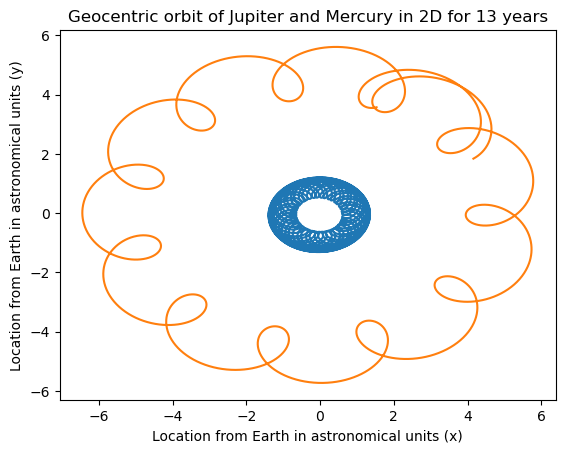

In [18]:
plt.plot(p1[0], p1[1])
plt.plot(p2[0], p2[1])
plt.title("Geocentric orbit of Jupiter and Mercury in 2D for 13 years")
plt.ylabel("Location from Earth in astronomical units (y)")
plt.xlabel("Location from Earth in astronomical units (x)")

(array([  81,  172,  262,  352,  442,  533,  623,  713,  803,  893,  983,
       1073, 1163, 1253, 1343, 1432, 1522, 1612, 1701, 1791, 1880, 1970,
       2059, 2149, 2238, 2327, 2417, 2506, 2595, 2685, 2774, 2863, 2953,
       3042, 3132, 3221, 3311, 3400, 3490, 3580, 3670, 3760, 3850, 3940,
       4030, 4121, 4211, 4301, 4391, 4482, 4572, 4662], dtype=int64), {})


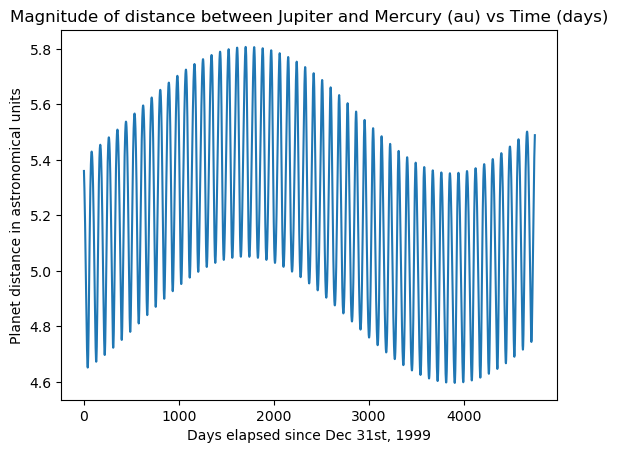

In [19]:
mag = np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2 + (p1[2] - p2[2]) ** 2 )
plt.plot(np.arange(0, const), mag)
plt.title("Magnitude of distance between Jupiter and Mercury (au) vs Time (days)")
plt.ylabel("Planet distance in astronomical units")
plt.xlabel("Days elapsed since Dec 31st, 1999")


print(find_peaks(mag))

(array([  53,  105,  107,  159,  161,  213,  215,  267,  279,  323,  375,
        379,  431, 4314, 4366, 4370, 4422, 4466, 4478, 4530, 4532, 4584,
       4586, 4638, 4640, 4692], dtype=int64), {})


Text(0.5, 0, 'Frequency')

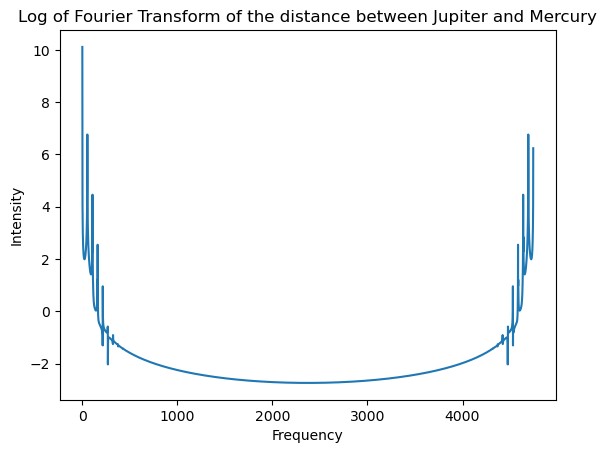

In [20]:
y = fft(mag)
z =np.log(abs(y))
plt.plot(z)
z1 = find_peaks(z)
print(z1)
plt.title("Log of Fourier Transform of the distance between Jupiter and Mercury")
plt.ylabel("Intensity")
plt.xlabel("Frequency")

In [35]:
# RA temp-func
def temp_func(n, const):    
    d = 0.0
    # x,y,z equatorial coordinates
    p1_0 = np.zeros((2, const))
    #sun_0 = np.zeros((2, const))
    for i in range (const):
        temp = om.getPlanPosGeo(n, d, ct="sphere", csys="equat")
        p1_0[0][i] = temp[0]
        p1_0[1][i] = temp[1]
        d += 1

    return p1_0

### WXML Testing - RA Distribution
Code for displaying the right ascension angle distribution of planets and the frequency of their appearance.

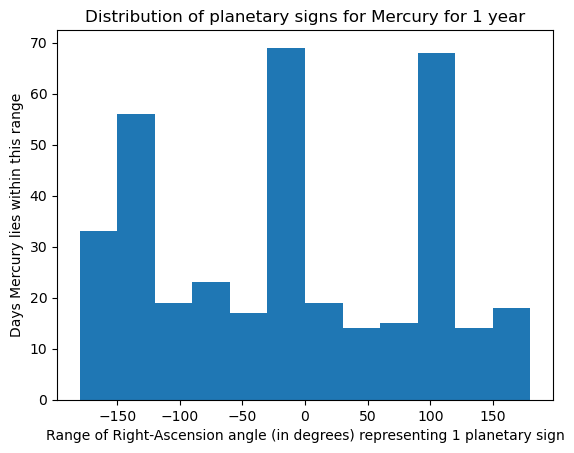

In [38]:
# Distribution of RA angles for Mercury 
const = 365
p1_0 = temp_func(1, const)

plt.hist(p1_0[0], bins = [-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
plt.title("Distribution of planetary signs for Mercury for 1 year")
plt.xlabel("Range of Right-Ascension angle (in degrees) representing 1 planetary sign")
plt.ylabel("Days Mercury lies within this range")
plt.show()

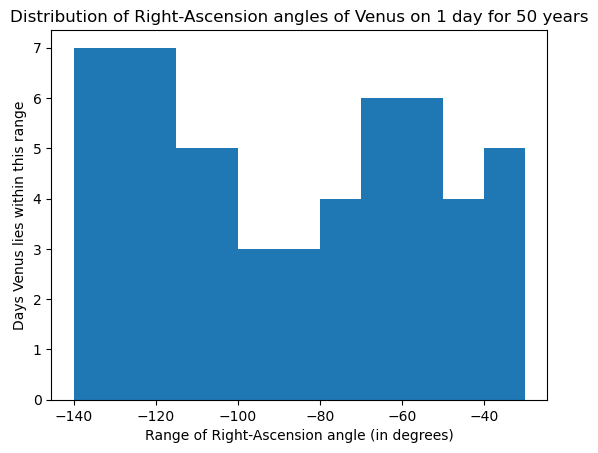

In [39]:
# Distribution of RA angles to Venus on 1 day for 50 years
const = 50*365
p1_0 = temp_func(2, const)
p1_2 = np.zeros(50)

# Get the nth year's value
for i in range(50):
    v = 365 * i
    p1_2[i] = p1_0[0][v]

plt.hist(p1_2, bins = [-140, -130, -115, -100, -90, -80, -70, -60, -50, -40, -30])
plt.title("Distribution of Right-Ascension angles of Venus on 1 day for 50 years")
plt.xlabel("Range of Right-Ascension angle (in degrees)")
plt.ylabel("Days Venus lies within this range")
plt.show()

In [40]:
# Numerical data on distribution values
p1_hist = np.histogram(p1_2, bins=[-140, -130, -115, -100, -90, -80, -70, -60, -50, -40, -30])

for i in range(len(p1_hist[0])):
    print("Days Venus lies in the sign of range [" +  str(p1_hist[1][i]) + "," + str(p1_hist[1][i+1]) + ") degrees: ", p1_hist[0][i])
p1_hist

# Make sure all data is covered within the provided range
sum = 0
for i in range(len(p1_hist[0])):
    sum += p1_hist[0][i]

print(sum)

Days Venus lies in the sign of range [-140,-130) degrees:  7
Days Venus lies in the sign of range [-130,-115) degrees:  7
Days Venus lies in the sign of range [-115,-100) degrees:  5
Days Venus lies in the sign of range [-100,-90) degrees:  3
Days Venus lies in the sign of range [-90,-80) degrees:  3
Days Venus lies in the sign of range [-80,-70) degrees:  4
Days Venus lies in the sign of range [-70,-60) degrees:  6
Days Venus lies in the sign of range [-60,-50) degrees:  6
Days Venus lies in the sign of range [-50,-40) degrees:  4
Days Venus lies in the sign of range [-40,-30) degrees:  5
50


### WXML Testing -- Entropy
Code for calculating entropy for these RA values and the displaying results.

In [10]:
'''
    A quick method for calculating the entropy of a system with discrete probabilities.
    We will check our calculated values with the scipy implementation.
    @param pdist: probability distribution of the events in a system
'''

def ent_calc(pdist):
    entropy = 0
    print("Rounded probabilities:", end=' ')
    for i in range(len(pdist)):
        px = pdist[i]
        # Probabilities (rounded)
        print("%.2f" %(px), end=' ')
        if px != 0:
            entropy += -px * np.log2(px)
    return entropy

In [11]:
# Our calculation
entval = ent_calc(p1_hist[0]/50)
print('\nCalculated Entropy:', entval)

# Scipy method 
print('Calculated Entropy (scipy method):', ent(p1_hist[0]/50, base=2))

# Normalized Value
print('Normalized Value:', entval/np.log2(len(p1_hist[0])))
# Max Value of Entropy
print('Max Entropy:', np.log2(len(p1_hist[0])))

Rounded probabilities: 0.14 0.14 0.10 0.06 0.06 0.08 0.12 0.12 0.08 0.10 
Calculated Entropy: 3.262824692361507
Calculated Entropy (scipy method): 3.262824692361507
Normalized Value: 0.9822081029939153
Max Entropy: 3.321928094887362


### WXML Testing -- Generated Keys
Code used to print decimal values to a file and for calculating entropy of final codes.

In [79]:
# Take the first 4 decimal values of the RA angle over whatever you're iterating over
# This sample is sampling at approximately the same day at 25 year intervals
# Sample codes: 9508 6876 6948 9025
const = 100*365
p1_0 = temp_func(2, const)

scripts = []
for i in range(0, 93, 1):
    temp = str (object=p1_0[0][i])
    scripts.append(temp[(temp.index('.'))+1:(temp.index('.'))+5])
    #print(temp[(temp.index('.'))+1:(temp.index('.'))+5])
    
    for j in range(1,5):
        temp1 = str (object=p1_0[0][i+(365*(25*j-1))])
        scripts[len(scripts)-1] = scripts[len(scripts)-1] + temp1[(temp1.index('.'))+1:(temp1.index('.'))+5]

In [80]:
# Export the codes to a file
f = open('25yrjump.txt', 'w')
for i in range(len(scripts)):
    f.write(scripts[i])
    f.write('\n')
f.close()

In [81]:
# Excerpt of randomized strings via Von-Neumann
# NOTE: The actual output of this differs since we'd used ecliptic instead of
# equatorial coords in the presentation
# Increment each day and collect over 4 days
st1 = "01001010111011010000011000010000000001101100101001010101110000000010000010101010010010110000001011100100000011000100000001001000"
# Increment by each month and collect over 4 months
st2 = "01001000100010010000100001001100101010101000100001000101000100001110110110000001010101101010100101000100000000011010000110010001"
# Increment by 25 years and collect over 100 years
st3 = "01001110000101010110000100010011101100101010000010000001000101000110110001000101011011011000110101011001000100110000011000101110"

gen_keys = np.array([st1, st2, st3])

In [82]:
'''
    Returns percentage distribution of 1's and 0's appearing in 
    Randomized string
'''
def sumBinarys(text):
    zeros = 0
    ones = 0
    for i in range(len(text)):
        if text[i] == '0':
            zeros+=1
        else:
            ones+=1

    return np.array([zeros/len(text), ones/len(text)])

In [83]:
# Entropy values for generated keys
for i in range(3):
    vals = sumBinarys(gen_keys[i])
    print("Percentage of zeros: ", vals[0])
    print("Percentage of ones: ", vals[1])
    print("Calculated entropy: ", ent(vals, base=2))

Percentage of zeros:  0.6640625
Percentage of ones:  0.3359375
Calculated entropy:  0.9208780154383215
Percentage of zeros:  0.65625
Percentage of ones:  0.34375
Calculated entropy:  0.9283620723948678
Percentage of zeros:  0.59375
Percentage of ones:  0.40625
Calculated entropy:  0.9744894033980523
